In [0]:
spark.read.table("ais.june").printSchema()

root
 |-- MMSI: string (nullable = true)
 |-- BaseDateTime: timestamp (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)
 |-- SOG: double (nullable = true)
 |-- COG: double (nullable = true)
 |-- Heading: double (nullable = true)
 |-- VesselName: string (nullable = true)
 |-- IMO: string (nullable = true)
 |-- CallSign: string (nullable = true)
 |-- VesselType: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Length: double (nullable = true)
 |-- Width: double (nullable = true)
 |-- Draft: double (nullable = true)
 |-- Cargo: string (nullable = true)
 |-- TranscieverClass: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- VesselGroup: integer (nullable = true)



In [0]:
spark.read.table("ais.june").count()

Out[3]: 249326112

In [0]:
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.types import FloatType
from math import radians, sin, cos, sqrt, asin

def haversine(lon1, lat1, lon2, lat2):
    RADIUS = 3440  # Radius of the earth in nautical miles
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return RADIUS * c

haversine_udf = F.udf(haversine, FloatType())

windowSpec = Window.partitionBy("MMSI").orderBy("BaseDateTime")

df = spark.read.table("ais.june")
df = df.withColumn("PrevLAT", F.lag(df["LAT"]).over(windowSpec))
df = df.withColumn("PrevLON", F.lag(df["LON"]).over(windowSpec))
df = df.withColumn("PrevBaseDateTime", F.lag(df["BaseDateTime"]).over(windowSpec))

# Filter out the rows with missing values
df = df.filter("PrevLAT is not null and PrevLON is not null and PrevBaseDateTime is not null")

df = df.withColumn("Distance", haversine_udf(F.col("LON"), F.col("LAT"), F.col("PrevLON"), F.col("PrevLAT")))

timeFmt = "yyyy-MM-dd'T'HH:mm:ss"
timeDiff = (F.unix_timestamp('BaseDateTime', format=timeFmt) - F.unix_timestamp('PrevBaseDateTime', format=timeFmt)) / 3600
df = df.withColumn("TimeDiff", timeDiff)

# Calculate SOG_approx with condition
df = df.withColumn("SOG_approx", 
                   F.when((F.col("LAT") == F.col("PrevLAT")) & (F.col("LON") == F.col("PrevLON")), 0)
                    .otherwise(df["Distance"] / df["TimeDiff"]))

df = df.drop("PrevLAT", "PrevLON", "PrevBaseDateTime", "Distance", "TimeDiff")

In [0]:
df.printSchema()

root
 |-- MMSI: string (nullable = true)
 |-- BaseDateTime: timestamp (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)
 |-- SOG: double (nullable = true)
 |-- COG: double (nullable = true)
 |-- Heading: double (nullable = true)
 |-- VesselName: string (nullable = true)
 |-- IMO: string (nullable = true)
 |-- CallSign: string (nullable = true)
 |-- VesselType: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Length: double (nullable = true)
 |-- Width: double (nullable = true)
 |-- Draft: double (nullable = true)
 |-- Cargo: string (nullable = true)
 |-- TranscieverClass: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- VesselGroup: integer (nullable = true)
 |-- SOG_approx: double (nullable = true)



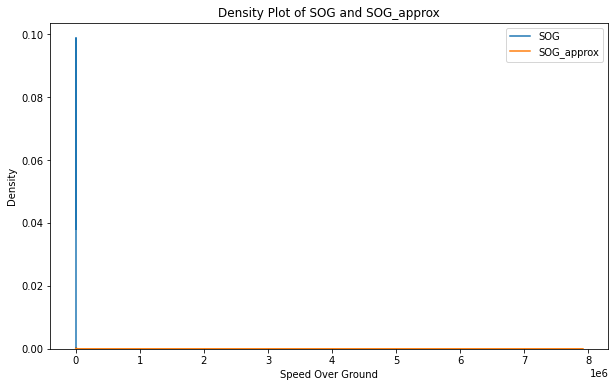

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Filter out the rows with NULL values in either "SOG" or "SOG_approx"
  = df.filter(F.col("SOG").isNotNull() & F.col("SOG_approx").isNotNull())

# Convert the filtered DataFrame to a Pandas DataFrame
pandas_df = df_filtered.select("SOG", "SOG_approx").toPandas()

# Create KDE plots
plt.figure(figsize=(10, 6))
sns.kdeplot(pandas_df["SOG"], label="SOG", bw_adjust=0.5)
sns.kdeplot(pandas_df["SOG_approx"], label="SOG_approx", bw_adjust=0.5)

# Customize the plot
plt.title('Density Plot of SOG and SOG_approx')
plt.xlabel('Speed Over Ground')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

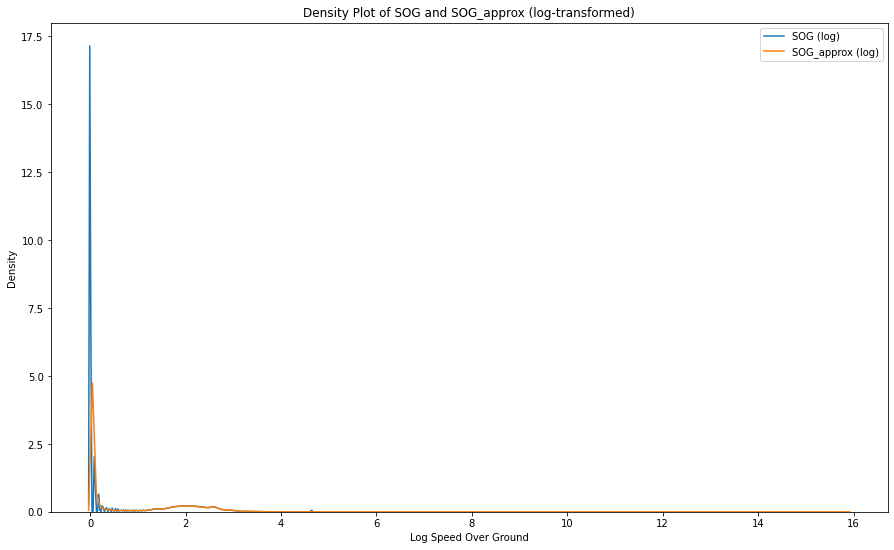

In [0]:
import numpy as np

# Apply logarithm transform
pandas_df["SOG_log"] = np.log1p(pandas_df["SOG"])
pandas_df["SOG_approx_log"] = np.log1p(pandas_df["SOG_approx"])

# Create KDE plots
plt.figure(figsize=(15, 9))
sns.kdeplot(pandas_df["SOG_log"], label="SOG (log)", bw_adjust=0.5)
sns.kdeplot(pandas_df["SOG_approx_log"], label="SOG_approx (log)", bw_adjust=0.5)

# Customize the plot
plt.title('Density Plot of SOG and SOG_approx (log-transformed)')
plt.xlabel('Log Speed Over Ground')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

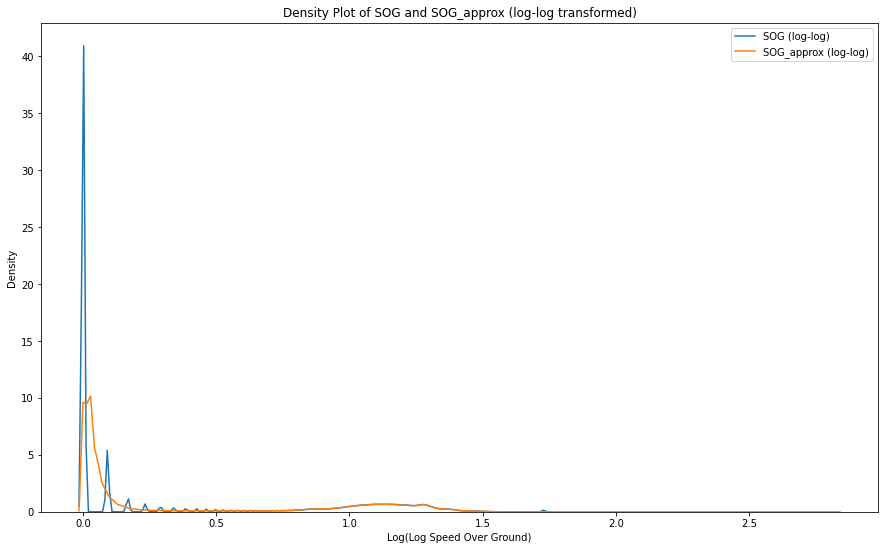

In [0]:
import numpy as np

# Apply double logarithm transform with handling for undefined values
# pandas_df["SOG_log"] = np.where(pandas_df["SOG"] > 0, np.log1p(np.log1p(pandas_df["SOG"])), np.nan)
# pandas_df["SOG_approx_log"] = np.where(pandas_df["SOG_approx"] > 0, np.log1p(np.log1p(pandas_df["SOG_approx"])), np.nan)

# Apply log-log transform
pandas_df["SOG_log"] = np.log1p(np.log1p(pandas_df["SOG"]))
pandas_df["SOG_approx_log"] = np.log1p(np.log1p(pandas_df["SOG_approx"]))

# Create KDE plots
plt.figure(figsize=(15, 9))
sns.kdeplot(pandas_df["SOG_log"], label="SOG (log-log)", bw_adjust=0.5)
sns.kdeplot(pandas_df["SOG_approx_log"], label="SOG_approx (log-log)", bw_adjust=0.5)

# Customize the plot
plt.title('Density Plot of SOG and SOG_approx (log-log transformed)')
plt.xlabel('Log(Log Speed Over Ground)')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Create the feature vector column
assembler = VectorAssembler(inputCols=["SOG", "SOG_approx"], outputCol="features")
df_vector = assembler.transform(df_filtered).select("features")

# Get correlation matrix
matrix = Correlation.corr(df_vector, "features")

# Extract the correlation coefficient
correlation = matrix.collect()[0]["pearson(features)"][0, 1]

print("Pearson correlation coefficient between SOG and SOG_approx:", correlation)


Pearson correlation coefficient between SOG and SOG_approx: 0.008262470986569138


In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Get correlation matrix using Spearman's rank correlation
matrix_spearman = Correlation.corr(df_vector, "features", method="spearman")

# Extract the correlation coefficient
correlation_spearman = matrix_spearman.collect()[0]["spearman(features)"][0, 1]

print("Spearman's rank correlation coefficient between SOG and SOG_approx:", correlation_spearman)


Spearman's rank correlation coefficient between SOG and SOG_approx: 0.7079089145589517


In [0]:
# Create a new DataFrame with the SOG_approx column
new_df = df.withColumn("SOG_approx", F.col("SOG_approx"))

# Overwrite the existing table with the updated data
new_df.write.mode("overwrite").option("overwriteSchema", "true").saveAsTable("ais.june")

In [0]:
df = spark.read.table("ais.june")

In [0]:
df.printSchema()

root
 |-- MMSI: string (nullable = true)
 |-- BaseDateTime: timestamp (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)
 |-- SOG: double (nullable = true)
 |-- COG: double (nullable = true)
 |-- Heading: double (nullable = true)
 |-- VesselName: string (nullable = true)
 |-- IMO: string (nullable = true)
 |-- CallSign: string (nullable = true)
 |-- VesselType: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Length: double (nullable = true)
 |-- Width: double (nullable = true)
 |-- Draft: double (nullable = true)
 |-- Cargo: string (nullable = true)
 |-- TranscieverClass: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- VesselGroup: integer (nullable = true)
 |-- SOG_approx: double (nullable = true)



In [0]:
import numpy as np
from pyspark.sql.functions import udf
from scipy.stats import kendalltau

# Define UDF for Kendall's tau
kendall_udf = udf(lambda x, y: float(kendalltau(x, y).correlation) if x and y else None)

# Apply UDF to compute Kendall's tau correlation coefficient
correlation_kendall = df.withColumn("kendall_tau", kendall_udf(df["SOG"], df["SOG_approx"]))

# Display the result
correlation_kendall.show()

+---------+-------------------+--------+---------+---+-----+-------+----------------+----------+--------+----------+------+------+-----+-----+-----+----------------+--------------------+-----------+--------------------+-----------+
|     MMSI|       BaseDateTime|     LAT|      LON|SOG|  COG|Heading|      VesselName|       IMO|CallSign|VesselType|Status|Length|Width|Draft|Cargo|TranscieverClass|            filename|VesselGroup|          SOG_approx|kendall_tau|
+---------+-------------------+--------+---------+---+-----+-------+----------------+----------+--------+----------+------+------+-----+-----+-----+----------------+--------------------+-----------+--------------------+-----------+
|209294000|2022-06-01 00:05:10|29.74636|-95.18792|0.0|343.0|   79.0|TWO MILLION WAYS|IMO9334571|   5BHK3|        80|     5| 228.0| 32.0| 14.4| null|               A|dbfs:/FileStore/t...|         80| 0.03180451691150665|       null|
|209294000|2022-06-01 00:08:09|29.74636|-95.18793|0.0|343.0|   79.0|TWO 